In [1]:
import os
import time
import json
import random
from typing import Dict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential, Input, optimizers
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import optuna
from optuna.integration import TFKerasPruningCallback

In [2]:
# --------------------------- User Config ---------------------------
CSV_PATH   = "ALL_MERGED.csv"
DATE_COL   = "Date"
TARGET_COL = "JKSE"
INCLUDE_TARGET_AS_FEATURE = True

TEST_SIZE  = 0.20
VAL_SIZE   = 0.10

N_TRIALS   = 50
RANDOM_SEED = 42
USE_PROGRESS_BAR = True

# MC Dropout
N_MC       = 100
ALPHA      = 0.05
USE_QUANTILES = True

# Visuals
DO_PLOTS   = True

# Output
CKPT_DIR   = "Model Checkpoints"
CKPT_PATH  = os.path.join(CKPT_DIR, "lstm_optuna_best.keras")
RESULTS_DIR = "Results"
os.makedirs(CKPT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

In [3]:
# --------------------------- Reproducibility ---------------------------
def load_seed_from_file(seed_file: str) -> int:
    if not os.path.exists(seed_file):
        raise FileNotFoundError(f"Seed file not found: {seed_file}")
    with open(seed_file, "r") as f:
        s = int(f.read().strip())
    return s

def set_global_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [4]:
# --------------------------- Data Loading ---------------------------
def load_dataset(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    required = [
        "Date", "Nickel_Fut", "Coal_Fut_Newcastle", "Palm_Oil_Fut",
        "USD_IDR", "CNY_IDR", "EUR_IDR", "BTC_USD",
        "FTSE100", "HANGSENG", "NIKKEI225", "SNP500", "DOW30", "SSE_Composite", TARGET_COL
    ]
    missing = [c for c in required if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")

    df[DATE_COL] = pd.to_datetime(df[DATE_COL])
    df = df.sort_values(DATE_COL).set_index(DATE_COL)
    df = df.ffill().bfill()
    return df

def split_df(df: pd.DataFrame, test_size: float, val_size: float):
    n = len(df)
    test_n = int(np.floor(test_size * n))
    trainval_n = n - test_n
    val_n = int(np.floor(val_size * trainval_n))
    train_n = trainval_n - val_n

    train_df = df.iloc[:train_n].copy()
    val_df   = df.iloc[train_n:train_n + val_n].copy()
    test_df  = df.iloc[train_n + val_n:].copy()
    return train_df, val_df, test_df

In [5]:
# --------------------------- Scaling & Windows ---------------------------
def get_feature_cols(df: pd.DataFrame, include_target: bool) -> list:
    return df.columns.tolist() if include_target else [c for c in df.columns if c != TARGET_COL]

def fit_scalers(train_df: pd.DataFrame, feature_cols: list):
    X_scaler = StandardScaler().fit(train_df[feature_cols])
    y_scaler = StandardScaler().fit(train_df[[TARGET_COL]])
    return X_scaler, y_scaler

def scale_block(block: pd.DataFrame, feature_cols: list, X_scaler: StandardScaler, y_scaler: StandardScaler):
    X = X_scaler.transform(block[feature_cols])
    y = y_scaler.transform(block[[TARGET_COL]])
    return (pd.DataFrame(X, index=block.index, columns=feature_cols),
            pd.DataFrame(y, index=block.index, columns=[TARGET_COL]))

def make_windows(X_df: pd.DataFrame, y_df: pd.DataFrame, lookback: int):
    X_vals = X_df.values
    y_vals = y_df.values.squeeze()
    idx = X_df.index

    X_list, y_list, idx_list = [], [], []
    for i in range(lookback, len(X_df)):
        X_list.append(X_vals[i - lookback:i, :])
        y_list.append(y_vals[i])
        idx_list.append(idx[i])

    X_arr = np.array(X_list, dtype=np.float32)
    y_arr = np.array(y_list, dtype=np.float32)
    idx_arr = np.array(idx_list)
    return X_arr, y_arr, idx_arr

In [6]:
# --------------------------- Metrics ---------------------------
def base_metrics(y_true, y_pred) -> Dict[str, float]:
    mse  = mean_squared_error(y_true, y_pred)
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return dict(MSE=float(mse), MAE=float(mae), RMSE=rmse, MAPE=float(mape), R2=float(r2))

def uq_metrics(y_true, L, U, alpha=0.10) -> Dict[str, float]:
    y = np.asarray(y_true); L = np.asarray(L); U = np.asarray(U)
    cover = (y >= L) & (y <= U)
    picp = float(cover.mean())
    mpiw = float(np.mean(U - L))
    penalty = np.where(y < L, (2/alpha)*(L - y),
              np.where(y > U, (2/alpha)*(y - U), 0.0))
    winkler = float(np.mean((U - L) + penalty))
    return dict(PICP=picp, MPIW=mpiw, Winkler=winkler)

In [7]:
# --------------------------- Model Builders ---------------------------
def build_lstm_from_trial(trial, lookback, n_features):
    num_layers = trial.suggest_int("num_layers", 1, 2)
    units1     = trial.suggest_int("units1", 32, 256, step=32)
    units2     = trial.suggest_int("units2", 32, 256, step=32) if num_layers == 2 else None
    dropout    = trial.suggest_float("dropout", 0.0, 0.5)
    lr         = trial.suggest_float("lr", 1e-4, 5e-3, log=True)

    m = Sequential()
    m.add(Input(shape=(lookback, n_features)))
    if num_layers == 2:
        m.add(LSTM(units1, return_sequences=True))
        m.add(Dropout(dropout))
        m.add(LSTM(units2))
    else:
        m.add(LSTM(units1))
    m.add(Dropout(dropout))  # same dropout used for MC
    m.add(Dense(1))
    m.compile(optimizer=optimizers.Adam(learning_rate=lr), loss="mse")
    return m

def build_lstm_fixed(best_params: dict, lookback: int, n_features: int):
    m = Sequential()
    m.add(Input(shape=(lookback, n_features)))
    if best_params.get("num_layers", 1) == 2:
        m.add(LSTM(best_params["units1"], return_sequences=True))
        m.add(Dropout(best_params["dropout"]))
        m.add(LSTM(best_params["units2"]))
    else:
        m.add(LSTM(best_params["units1"]))
    m.add(Dropout(best_params["dropout"]))
    m.add(Dense(1))
    m.compile(optimizer=optimizers.Adam(learning_rate=best_params["lr"]), loss="mse")
    return m

In [8]:
# --------------------------- Optuna Objective ---------------------------
def make_objective(X_train_s, y_train_s, X_val_s, y_val_s, n_features):
    def objective(trial):
        lookback = trial.suggest_categorical("lookback", [30, 45, 60, 90])
        X_tr, y_tr, _ = make_windows(X_train_s, y_train_s, lookback)
        X_va, y_va, _ = make_windows(X_val_s,   y_val_s,   lookback)

        batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
        epochs     = trial.suggest_int("epochs", 30, 90, step=10)
        patience   = trial.suggest_int("patience", 5, 10)

        model = build_lstm_from_trial(trial, lookback, n_features=n_features)
        callbacks = [
            EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True),
            TFKerasPruningCallback(trial, monitor="val_loss"),
        ]

        history = model.fit(
            X_tr, y_tr,
            validation_data=(X_va, y_va),
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
            callbacks=callbacks
        )
        return float(min(history.history["val_loss"]))
    return objective

In [9]:
# --------------------------- Deterministic Predictions ---------------------------
def predict_series(model, X_block, idx_block, y_scaler):
    yhat_s = model.predict(X_block, verbose=0)
    yhat = y_scaler.inverse_transform(yhat_s).squeeze()
    return pd.Series(yhat, index=idx_block, name="Pred")

In [10]:
# --------------------------- MC Dropout ---------------------------
@tf.function
def mc_call(m, X, training=True):
    # keep dropout active during inference
    return m(X, training=training)

def predict_mc(model, X_np, idx, y_mean: float, y_scale: float,
               n_mc: int = 100, use_quantiles: bool = True, alpha: float = 0.10):
    Ys_scaled = []
    X_tf = tf.convert_to_tensor(X_np, dtype=tf.float32)
    for _ in range(n_mc):
        y_s = mc_call(model, X_tf, training=True).numpy().squeeze()  # (N,)
        Ys_scaled.append(y_s)
    Ys_scaled = np.stack(Ys_scaled, axis=1)  # (N, T)
    Ys = Ys_scaled * y_scale + y_mean        # inverse scale: y = z*scale + mean

    mean = Ys.mean(axis=1)
    std  = Ys.std(axis=1, ddof=1)
    if use_quantiles:
        lower = np.quantile(Ys, q=alpha/2, axis=1)
        upper = np.quantile(Ys, q=1 - alpha/2, axis=1)
    else:
        from scipy.stats import norm
        z = norm.ppf(1 - alpha/2.0)
        lower, upper = mean - z*std, mean + z*std

    return (
        pd.Series(mean,  index=idx, name="mean"),
        pd.Series(lower, index=idx, name=f"lower_{int((1-alpha)*100)}"),
        pd.Series(upper, index=idx, name=f"upper_{int((1-alpha)*100)}"),
        pd.Series(std,   index=idx, name="mc_std"),
        Ys  # raw MC draws in real scale: shape (N, T)
    )

In [11]:
# --------------------------- Main ---------------------------
def main():
    # Seed
    print("Seed:", RANDOM_SEED)
    set_global_seed(RANDOM_SEED)

    # Data
    df = load_dataset(CSV_PATH)
    train_df, val_df, test_df = split_df(df, TEST_SIZE, VAL_SIZE)

    feature_cols = get_feature_cols(df, INCLUDE_TARGET_AS_FEATURE)
    X_scaler, y_scaler = fit_scalers(train_df, feature_cols)

    X_train_s, y_train_s = scale_block(train_df, feature_cols, X_scaler, y_scaler)
    X_val_s,   y_val_s   = scale_block(val_df,   feature_cols, X_scaler, y_scaler)
    X_test_s,  y_test_s  = scale_block(test_df,  feature_cols, X_scaler, y_scaler)

    y_mean, y_scale = float(y_scaler.mean_[0]), float(y_scaler.scale_[0])

    # ------------------ Optuna ------------------
    print("\n[Optuna] Starting study...")
    sampler = optuna.samplers.TPESampler(seed=RANDOM_SEED)
    pruner  = optuna.pruners.MedianPruner(n_warmup_steps=5)
    study   = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)

    objective = make_objective(X_train_s, y_train_s, X_val_s, y_val_s, n_features=len(feature_cols))
    study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=USE_PROGRESS_BAR)
    best_params = study.best_params
    BEST_LOOKBACK = best_params["lookback"]
    print("[Optuna] Best params:", best_params)

    # ------------------ Windows with best lookback ------------------
    X_train_w, y_train_w, idx_train = make_windows(X_train_s, y_train_s, BEST_LOOKBACK)
    X_val_w,   y_val_w,   idx_val   = make_windows(X_val_s,   y_val_s,   BEST_LOOKBACK)
    X_test_w,  y_test_w,  idx_test  = make_windows(X_test_s,  y_test_s,  BEST_LOOKBACK)

    # ------------------ Final deterministic training ------------------
    final_model = build_lstm_fixed(best_params, BEST_LOOKBACK, len(feature_cols))
    callbacks = [
        EarlyStopping(monitor="val_loss", patience=best_params["patience"], restore_best_weights=True),
        ModelCheckpoint(CKPT_PATH, monitor="val_loss", save_best_only=True)
    ]

    print("\n[Train] Retraining final LSTM with best params...")
    t0 = time.time()
    history = final_model.fit(
        X_train_w, y_train_w,
        validation_data=(X_val_w, y_val_w),
        epochs=best_params["epochs"],
        batch_size=best_params["batch_size"],
        verbose=1,
        callbacks=callbacks
    )
    print(f"[Train] Done in {time.time()-t0:.2f}s")

    # ------------------ Deterministic predictions (Stage 1 comparability) ------------------
    actual = df[TARGET_COL]
    actual_train = actual.loc[idx_train]
    actual_val   = actual.loc[idx_val]
    actual_test  = actual.loc[idx_test]

    pred_train_det = predict_series(final_model, X_train_w, idx_train, y_scaler)
    pred_val_det   = predict_series(final_model, X_val_w,   idx_val,   y_scaler)
    pred_test_det  = predict_series(final_model, X_test_w,  idx_test,  y_scaler)

    print("\n=== Stage-1 Point Forecast Metrics (same model used later for MC) ===")
    print("Train:", base_metrics(actual_train.values, pred_train_det.values))
    print("Val:  ", base_metrics(actual_val.values,   pred_val_det.values))
    print("Test: ", base_metrics(actual_test.values,  pred_test_det.values))

    # ------------------ Load the SAME trained model for MC ------------------
    same_model = tf.keras.models.load_model(CKPT_PATH, compile=False)
    same_model.compile(optimizer=optimizers.Adam(learning_rate=best_params["lr"]), loss="mse")

    print("\n[MC] Running Monte Carlo Dropout inference with same trained weights...")
    mean_train, L_train, U_train, std_train, Ys_train = predict_mc(
        same_model, X_train_w, idx_train, y_mean, y_scale, n_mc=N_MC, use_quantiles=USE_QUANTILES, alpha=ALPHA
    )
    mean_val,   L_val,   U_val,   std_val,   Ys_val   = predict_mc(
        same_model, X_val_w,   idx_val,   y_mean, y_scale, n_mc=N_MC, use_quantiles=USE_QUANTILES, alpha=ALPHA
    )
    mean_test,  L_test,  U_test,  std_test,  Ys_test  = predict_mc(
        same_model, X_test_w,  idx_test,  y_mean, y_scale, n_mc=N_MC, use_quantiles=USE_QUANTILES, alpha=ALPHA
    )

    # Stage-2 Point Forecast Metrics (after MC Dropout)
    print(f"\n=== Stage-2 Point Forecast Metrics (MC Mean) ===")
    print("Train:", base_metrics(actual_train.values, mean_train.values))
    print("Val:  ", base_metrics(actual_val.values,   mean_val.values))
    print("Test: ", base_metrics(actual_test.values,  mean_test.values))

    print(f"\n=== Stage-2 UQ Metrics ({int((1-ALPHA)*100)}% PI) ===")
    print("Train:", uq_metrics(actual_train.values, L_train.values, U_train.values, ALPHA))
    print("Val:  ", uq_metrics(actual_val.values,   L_val.values,   U_val.values,   ALPHA))
    print("Test: ", uq_metrics(actual_test.values,  L_test.values,  U_test.values,  ALPHA))

    # ------------------ Epistemic vs Aleatoric (approximate split) ------------------
    resid_val = actual_val.values - mean_val.values
    sigma2_aleatoric = float(np.var(resid_val, ddof=1))
    var_total_test   = np.var(Ys_test, axis=1, ddof=1)
    var_epistemic    = np.maximum(0.0, var_total_test - sigma2_aleatoric)
    var_aleatoric    = np.full_like(var_total_test, sigma2_aleatoric)

    # Save artifacts
    best_json_path = os.path.join(RESULTS_DIR, "lstm_best_params.json")
    with open(best_json_path, "w") as f:
        json.dump(best_params, f, indent=2)
    print(f"\nSaved best params to: {best_json_path}")
    print(f"Saved trained model to: {CKPT_PATH}")

    # ------------------ Visualizations ------------------
    if DO_PLOTS:
        plt.figure(figsize=(12,5))
        plt.plot(df.index, df[TARGET_COL].values, label="Actual", linewidth=1)
        plt.plot(mean_train.index, mean_train.values, label="Pred (Train, MC mean)", linewidth=1)
        plt.plot(mean_val.index,   mean_val.values,   label="Pred (Val, MC mean)", linewidth=1)
        plt.plot(mean_test.index,  mean_test.values,  label="Pred (Test, MC mean)", linewidth=1.5)
        plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.25, label=f"{int((1-ALPHA)*100)}% PI (Test)")
        plt.title("All Actual vs Predicted — LSTM (Optuna) + MC Dropout")
        plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

        # inside/outside markers on Test
        y_true = actual_test.values; L_arr = L_test.values; U_arr = U_test.values
        inside = (y_true >= L_arr) & (y_true <= U_arr)
        outside = ~inside

        plt.figure(figsize=(12,5))
        plt.plot(actual_test.index, actual_test.values, label="Actual (Test)", linewidth=1.5)
        plt.plot(mean_test.index,   mean_test.values,   label="Pred (Test, MC mean)", linewidth=1.5)
        plt.fill_between(L_test.index, L_test.values, U_test.values, alpha=0.30, label=f"{int((1-ALPHA)*100)}% PI")
        plt.scatter(actual_test.index[inside],  actual_test.values[inside],  s=15, label="Inside PI", zorder=3)
        plt.scatter(actual_test.index[outside], actual_test.values[outside], s=25, marker="x", label="Outside PI", zorder=3)
        plt.title("Test Horizon: Actual vs MC Mean with Prediction Interval (+ inside/outside)")
        plt.xlabel("Date"); plt.ylabel(TARGET_COL); plt.legend(); plt.tight_layout(); plt.show()

        # residuals
        residuals_test = pd.Series(actual_test.values - mean_test.values, index=actual_test.index, name="Residuals")
        plt.figure(figsize=(12,4))
        plt.plot(residuals_test.index, residuals_test.values, linewidth=1)
        plt.axhline(0, ls="--", lw=1); plt.title("Residuals Over Time (Test) — LSTM + MC")
        plt.xlabel("Date"); plt.ylabel("Actual - Pred"); plt.tight_layout(); plt.show()

        # uncertainty decomposition
        plt.figure(figsize=(12,5))
        plt.plot(idx_test, var_epistemic, label="Epistemic Var (≈)", linewidth=1)
        plt.plot(idx_test, var_aleatoric, label="Aleatoric Var (proxy)", linewidth=1)
        plt.plot(idx_test, var_total_test, label="Total Predictive Var (MC)", linewidth=1.2)
        plt.title("Uncertainty Decomposition Over Time (Test)")
        plt.xlabel("Date"); plt.ylabel("Variance"); plt.legend(); plt.tight_layout(); plt.show()

        # ===================== (a) Coverage heatmap (per-window) =====================
        from matplotlib.colors import ListedColormap, BoundaryNorm
        WINDOW_LEN = 30
        STRIDE     = 10

        y_true = actual_test.values
        L_arr  = L_test.values
        U_arr  = U_test.values
        below_mask  = (y_true < L_arr)
        above_mask  = (y_true > U_arr)
        inside_mask = (y_true >= L_arr) & (y_true <= U_arr)

        status = np.zeros_like(y_true, dtype=int)
        status[below_mask] = -1
        status[above_mask] =  1

        starts = np.arange(0, len(status)-WINDOW_LEN+1, STRIDE)
        if len(starts) == 0:
            starts = np.array([0]); WINDOW_LEN = len(status)

        mat = []
        x_tick_labels = []
        for s in starts:
            e = min(s + WINDOW_LEN, len(status))
            row = status[s:e]
            if e - s < WINDOW_LEN:
                row = np.pad(row, (0, WINDOW_LEN - (e - s)), constant_values=np.nan)
            mat.append(row)
            x_tick_labels.append(actual_test.index[s].strftime('%Y-%m-%d'))
        mat = np.vstack(mat)

        cmap   = ListedColormap(["#d62728", "#2ca02c", "#ff7f0e", "#bdbdbd"])  # red, green, orange, grey
        bounds = [-1.5, -0.5, 0.5, 1.5, 2.5]
        norm   = BoundaryNorm(bounds, cmap.N)

        plt.figure(figsize=(12,6))
        plt.imshow(mat, aspect="auto", interpolation="nearest", cmap=cmap, norm=norm)
        plt.title(f"Coverage Heatmap (Test) — window={WINDOW_LEN}, stride={STRIDE}\n-1: Below | 0: Inside | +1: Above")
        plt.xlabel("Position inside window"); plt.ylabel("Window start time")
        yticks = np.arange(0, len(starts), max(1, len(starts)//10))
        plt.yticks(yticks, [x_tick_labels[i] for i in yticks])
        import matplotlib.patches as mpatches
        legend_patches = [
            mpatches.Patch(color="#2ca02c", label="Inside PI"),
            mpatches.Patch(color="#d62728", label="Below lower"),
            mpatches.Patch(color="#ff7f0e", label="Above upper"),
            mpatches.Patch(color="#bdbdbd", label="Padding")
        ]
        plt.legend(handles=legend_patches, loc="upper right", frameon=True)
        plt.tight_layout(); plt.show()

        # ===================== Rolling PICP (calibration drift) =====================
        ROLL_LEN = 30
        y_true = actual_test.values; L_arr = L_test.values; U_arr = U_test.values
        inside_series = pd.Series(((y_true >= L_arr) & (y_true <= U_arr)).astype(int), index=actual_test.index, name="inside")
        rolling_picp = inside_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()

        plt.figure(figsize=(12,4))
        plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label=f"Rolling PICP (window={ROLL_LEN})")
        plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
        plt.ylim(0, 1.05)
        plt.title("Rolling PICP on Test (Calibration over Time)")
        plt.xlabel("Date"); plt.ylabel("Coverage")
        plt.legend(); plt.tight_layout(); plt.show()

        # ===================== Rolling MPIW (sharpness drift) =====================
        width_series = pd.Series((U_arr - L_arr), index=actual_test.index, name="PI_width")
        rolling_mpiw = width_series.rolling(window=ROLL_LEN, center=True, min_periods=max(3, ROLL_LEN//3)).mean()
        overall_mpiw_test = width_series.mean()

        plt.figure(figsize=(12,4))
        plt.plot(rolling_mpiw.index, rolling_mpiw.values, linewidth=1.8, label=f"Rolling MPIW (window={ROLL_LEN})")
        plt.axhline(overall_mpiw_test, ls="--", lw=1, label=f"Overall MPIW (Test) = {overall_mpiw_test:.2f}")
        plt.title("Rolling MPIW on Test (Sharpness over Time)")
        plt.xlabel("Date"); plt.ylabel("Interval Width")
        plt.legend(); plt.tight_layout(); plt.show()

        # ===================== Rolling PICP vs Normalized MPIW (combined) =====================
        norm_mpiw = (rolling_mpiw - np.nanmin(rolling_mpiw)) / (np.nanmax(rolling_mpiw) - np.nanmin(rolling_mpiw) + 1e-12)
        plt.figure(figsize=(12, 4))
        plt.plot(rolling_picp.index, rolling_picp.values, linewidth=1.8, label="Rolling PICP (0–1)")
        plt.plot(norm_mpiw.index, norm_mpiw.values, linewidth=1.5, label="Rolling MPIW (normalized 0–1)")
        plt.axhline(1 - ALPHA, ls="--", lw=1, label=f"Target coverage = {1-ALPHA:.2f}")
        plt.title("Rolling PICP vs Normalized Rolling MPIW (Test)")
        plt.xlabel("Date"); plt.ylabel("Scaled value")
        plt.legend(); plt.tight_layout(); plt.show()

        # ===================== Stage-1 vs Stage-2 Metrics Comparison =====================
        # Calculate Stage-1 metrics (deterministic)
        stage1_train = base_metrics(actual_train.values, pred_train_det.values)
        stage1_val   = base_metrics(actual_val.values,   pred_val_det.values)
        stage1_test  = base_metrics(actual_test.values,  pred_test_det.values)

        # Stage-2 metrics already computed (MC mean)
        stage2_train = base_metrics(actual_train.values, mean_train.values)
        stage2_val   = base_metrics(actual_val.values,   mean_val.values)
        stage2_test  = base_metrics(actual_test.values,  mean_test.values)

        # Prepare data for plotting
        metrics_names = ["MAE", "MSE", "MAPE", "RMSE", "R2"]
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()

        for idx, metric in enumerate(metrics_names):
            ax = axes[idx]
            stage1_vals = [stage1_train[metric], stage1_val[metric], stage1_test[metric]]
            stage2_vals = [stage2_train[metric], stage2_val[metric], stage2_test[metric]]

            x = np.arange(3)
            width = 0.35

            bars1 = ax.bar(x - width/2, stage1_vals, width, label="Stage-1 (Deterministic)", alpha=0.8, color="#1f77b4")
            bars2 = ax.bar(x + width/2, stage2_vals, width, label="Stage-2 (MC Mean)", alpha=0.8, color="#ff7f0e")

            ax.set_xlabel("Split")
            ax.set_ylabel(metric)
            ax.set_title(f"{metric} Comparison: Stage-1 vs Stage-2")
            ax.set_xticks(x)
            ax.set_xticklabels(["Train", "Val", "Test"])
            ax.legend()
            ax.grid(axis="y", alpha=0.3)

            # Add value labels on bars
            for bar in bars1:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=8)
            for bar in bars2:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=8)

        # Remove the extra subplot
        fig.delaxes(axes[-1])

        plt.tight_layout()
        plt.show()

        # Print summary table
        print("\n=== Stage-1 vs Stage-2 Point Forecast Metrics Comparison ===")
        comparison_data = []
        for split, stage1, stage2 in [
            ("Train", stage1_train, stage2_train),
            ("Val", stage1_val, stage2_val),
            ("Test", stage1_test, stage2_test),
        ]:
            for metric in metrics_names:
                diff = stage2[metric] - stage1[metric]
                pct_change = (diff / stage1[metric] * 100) if stage1[metric] != 0 else 0
                comparison_data.append({
                    "Split": split,
                    "Metric": metric,
                    "Stage-1": round(stage1[metric], 6),
                    "Stage-2": round(stage2[metric], 6),
                    "Difference": round(diff, 6),
                    "% Change": round(pct_change, 2)
                })

        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))

    print("\n[Done] Integrated LSTM pipeline finished successfully.")


[I 2025-11-25 22:20:43,371] A new study created in memory with name: no-name-09a089ec-bc6b-4cf8-b098-8bcff9173502


Seed: 42

[Optuna] Starting study...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-25 22:22:52,908] Trial 0 finished with value: 0.25342440605163574 and parameters: {'lookback': 45, 'batch_size': 32, 'epochs': 90, 'patience': 8, 'num_layers': 2, 'units1': 32, 'units2': 256, 'dropout': 0.41622132040021087, 'lr': 0.00022948683681130568}. Best is trial 0 with value: 0.25342440605163574.
[I 2025-11-25 22:24:18,040] Trial 1 finished with value: 0.04440448805689812 and parameters: {'lookback': 90, 'batch_size': 128, 'epochs': 30, 'patience': 6, 'num_layers': 1, 'units1': 128, 'dropout': 0.3925879806965068, 'lr': 0.00021839352923182988}. Best is trial 1 with value: 0.04440448805689812.
[I 2025-11-25 22:24:36,945] Trial 2 finished with value: 0.04660867899656296 and parameters: {'lookback': 90, 'batch_size': 128, 'epochs': 90, 'patience': 9, 'num_layers': 1, 'units1': 32, 'dropout': 0.34211651325607845, 'lr': 0.0005595074635794797}. Best is trial 1 with value: 0.04440448805689812.
[I 2025-11-25 22:27:15,472] Trial 3 finished with value: 0.008020524866878986 and pa

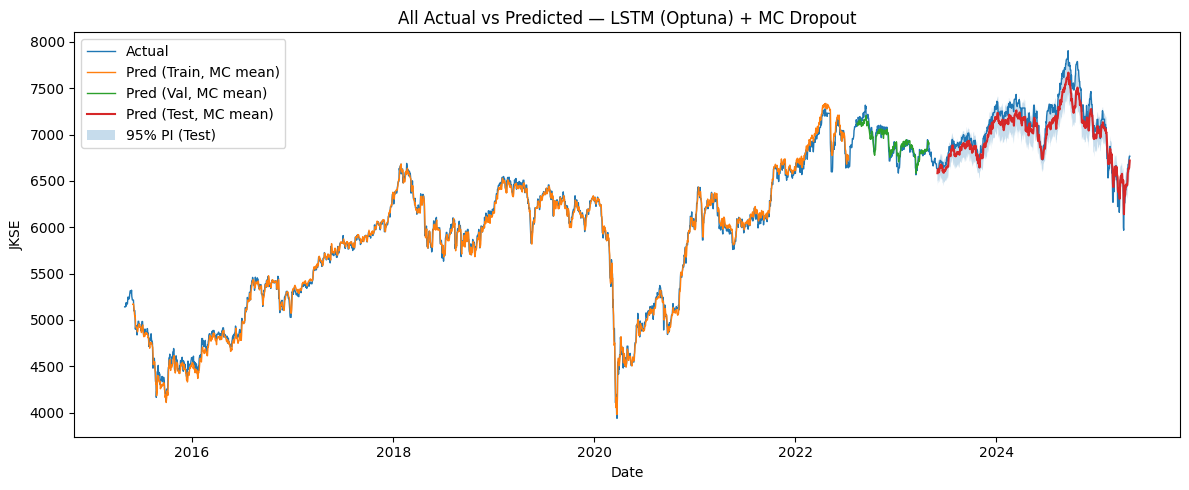

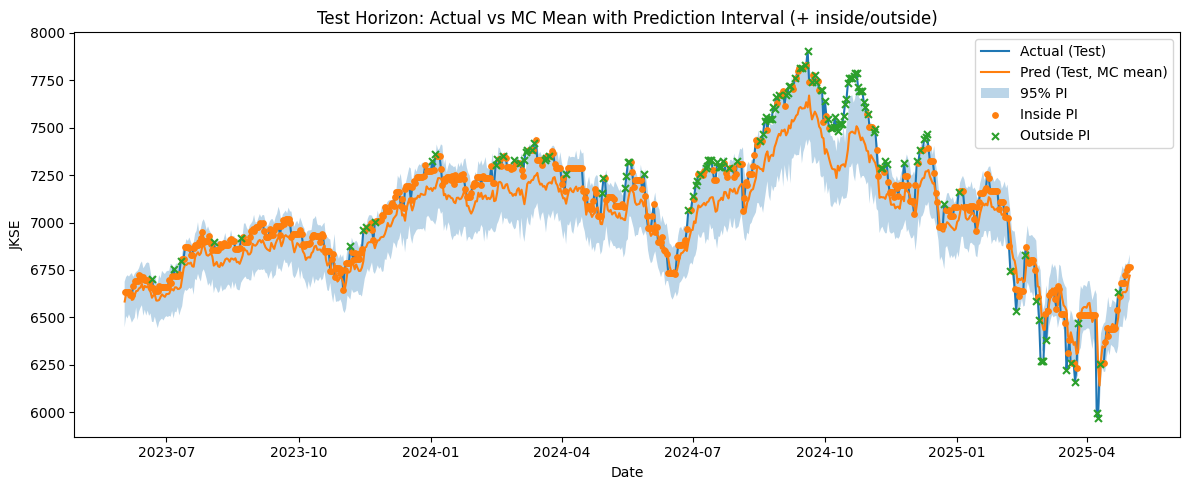

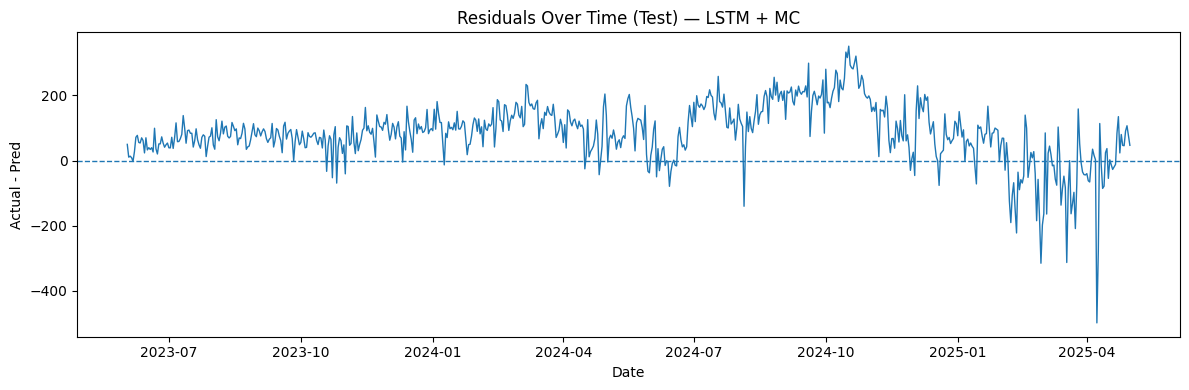

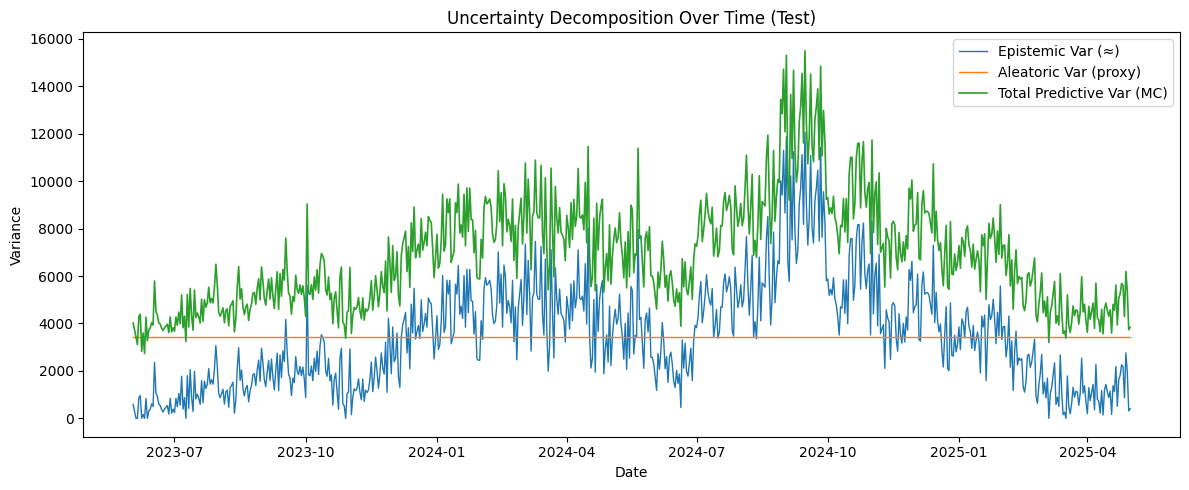

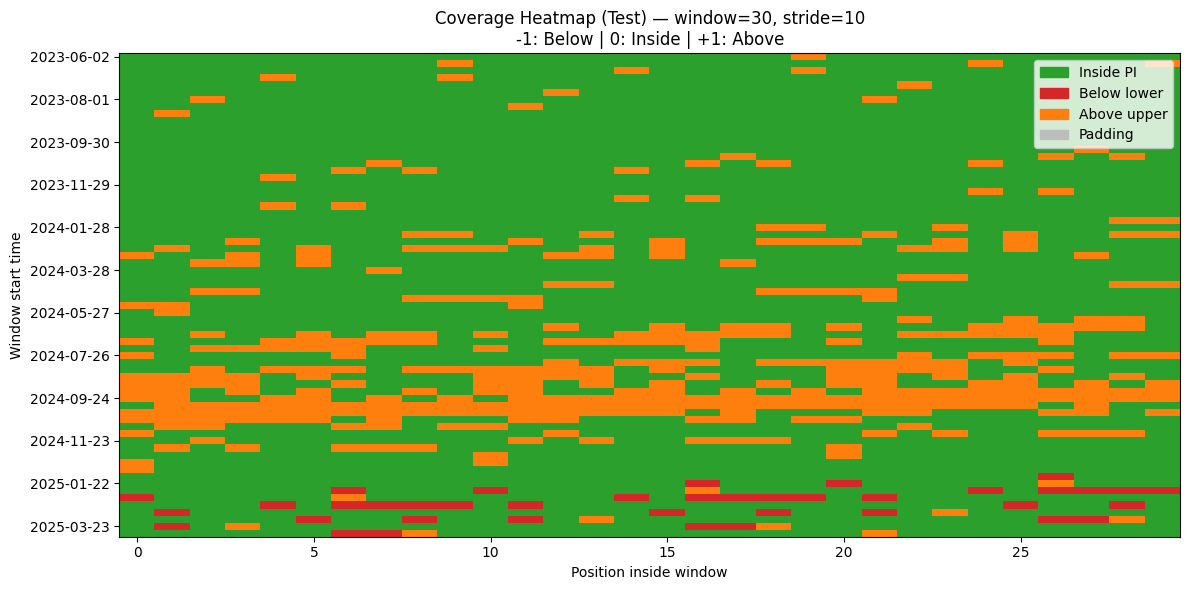

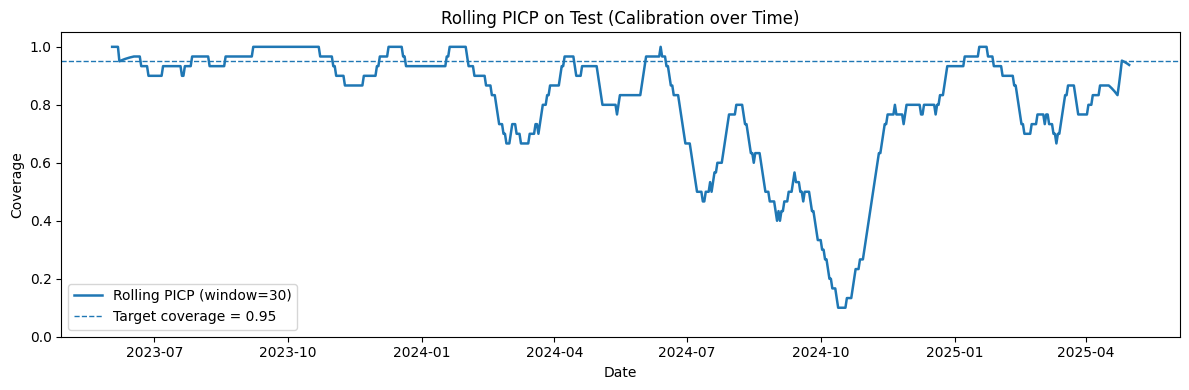

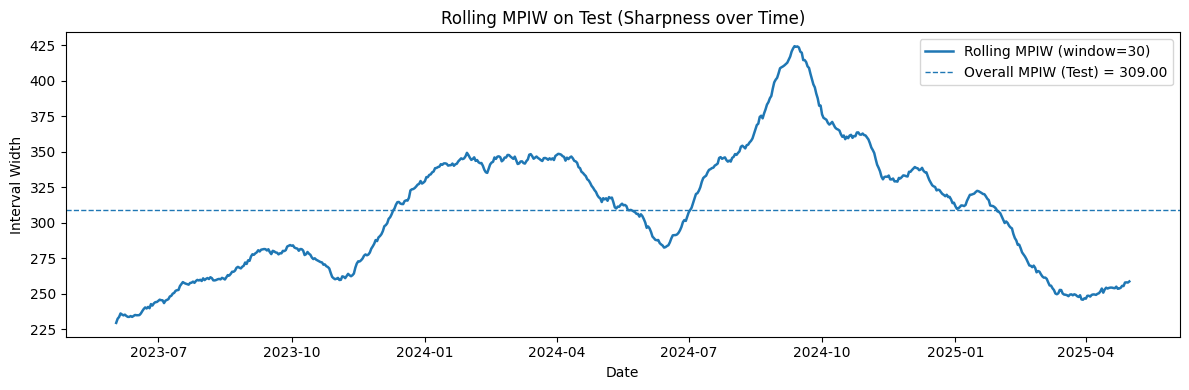

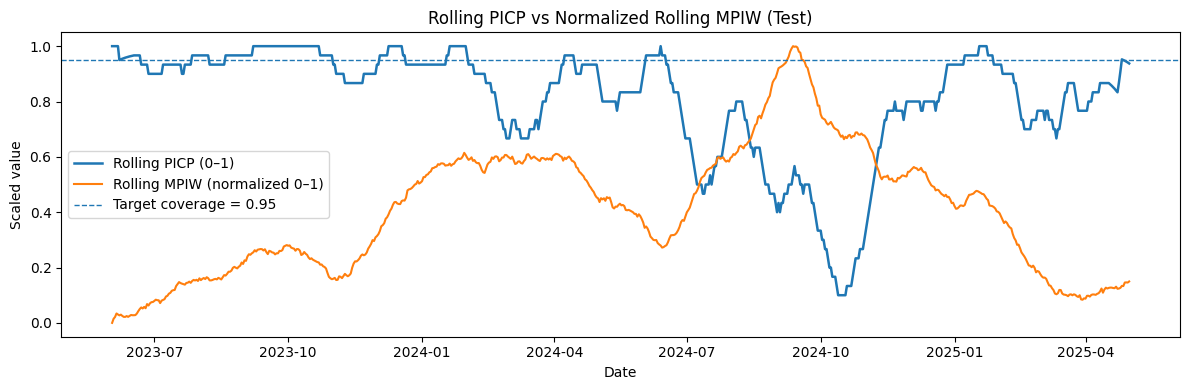

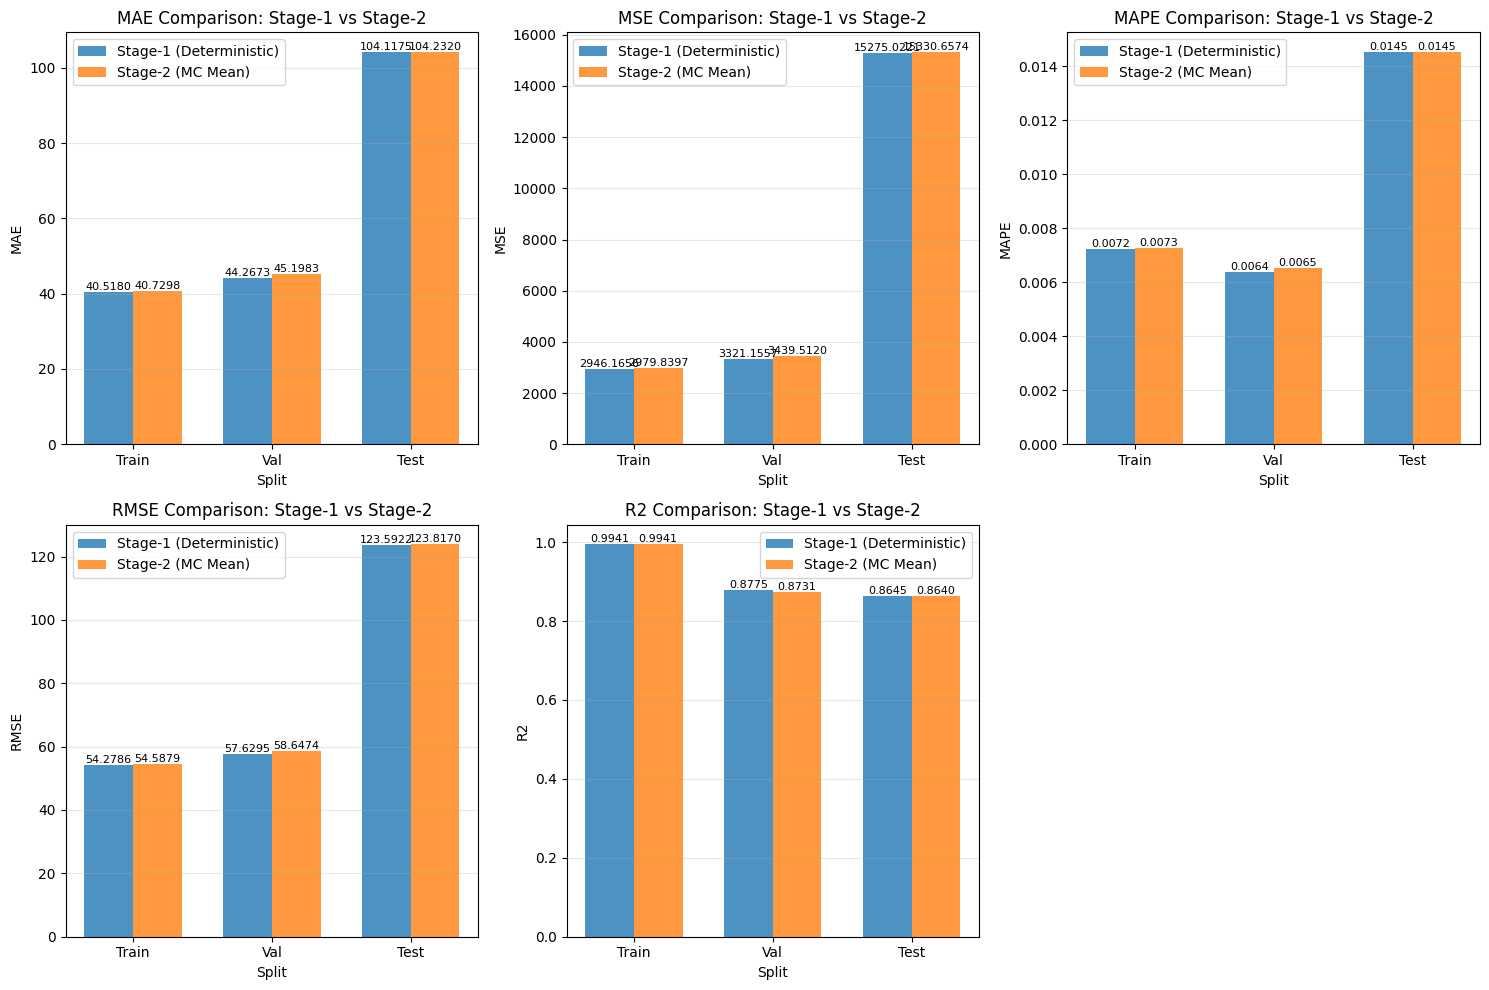


=== Stage-1 vs Stage-2 Point Forecast Metrics Comparison ===
Split Metric      Stage-1      Stage-2  Difference  % Change
Train    MAE    40.517973    40.729753    0.211780      0.52
Train    MSE  2946.165641  2979.839735   33.674094      1.14
Train   MAPE     0.007219     0.007256    0.000037      0.51
Train   RMSE    54.278593    54.587908    0.309315      0.57
Train     R2     0.994133     0.994066   -0.000067     -0.01
  Val    MAE    44.267263    45.198319    0.931055      2.10
  Val    MSE  3321.155730  3439.511989  118.356259      3.56
  Val   MAPE     0.006381     0.006521    0.000140      2.19
  Val   RMSE    57.629469    58.647353    1.017884      1.77
  Val     R2     0.877461     0.873094   -0.004367     -0.50
 Test    MAE   104.117455   104.231998    0.114542      0.11
 Test    MSE 15275.022052 15330.657437   55.635384      0.36
 Test   MAPE     0.014509     0.014526    0.000017      0.12
 Test   RMSE   123.592160   123.817032    0.224872      0.18
 Test     R2     0.8644

In [12]:
if __name__ == "__main__":
    main()